In [1545]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1546]:
#Set variables that always change during the cleaning
# I just changed for each variable the year and the corresponding S&P500 value
ds2014 = pd.read_csv("dataset/2014_Financial_Data.csv")
price = "2015 PRICE VAR [%]"
fileName = "Cleaned_2014.csv"
outliers_percentage = 300
sp_price_var = -0.73 # -0.73, 9.54, 19.42, -6.24, 28.88
benchmark = 2.5
sp500_2015_buy = sp_price_var + benchmark
sp500_2015_sell = sp_price_var - benchmark

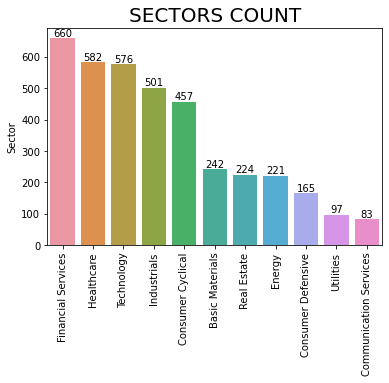

In [1547]:
# Plot sector distribution, to see what data do we have
df_sector = ds2014['Sector'].value_counts()
plotSector = sns.barplot(np.arange(len(df_sector)), df_sector)
plotSector.bar_label(plotSector.containers[0])
plt.xticks(np.arange(len(df_sector)), df_sector.index.values.tolist(), rotation=90)
plt.title('SECTORS COUNT', fontsize=20)
plt.show()

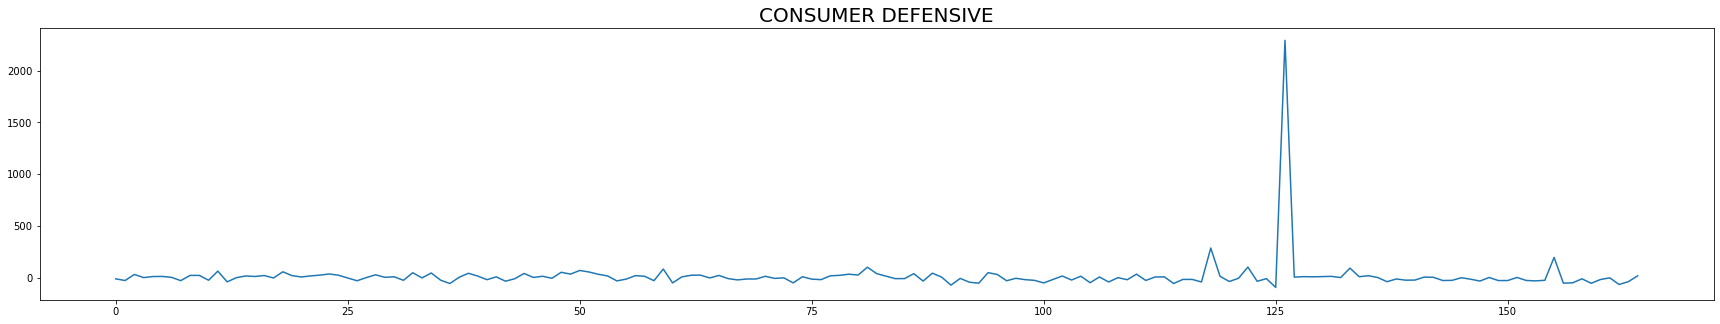

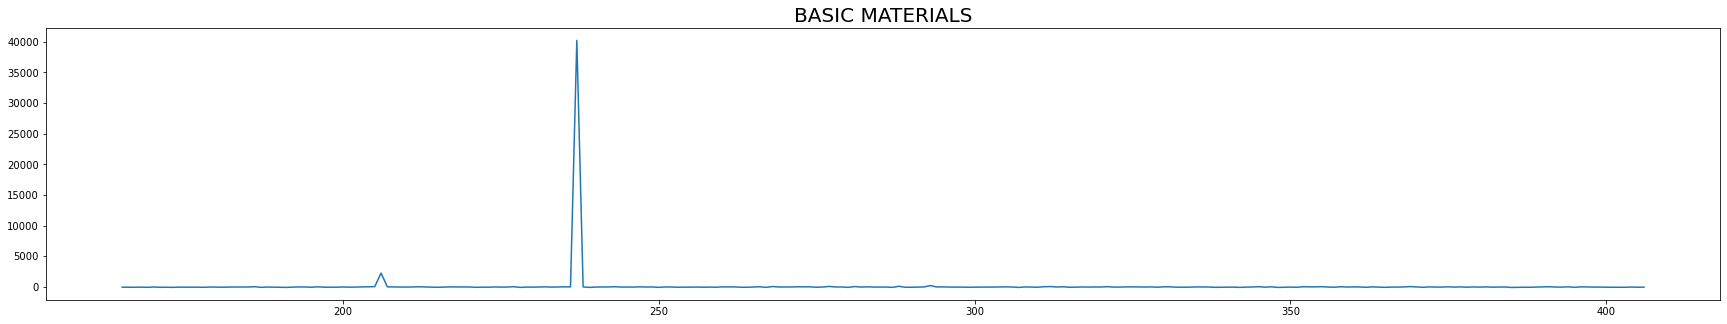

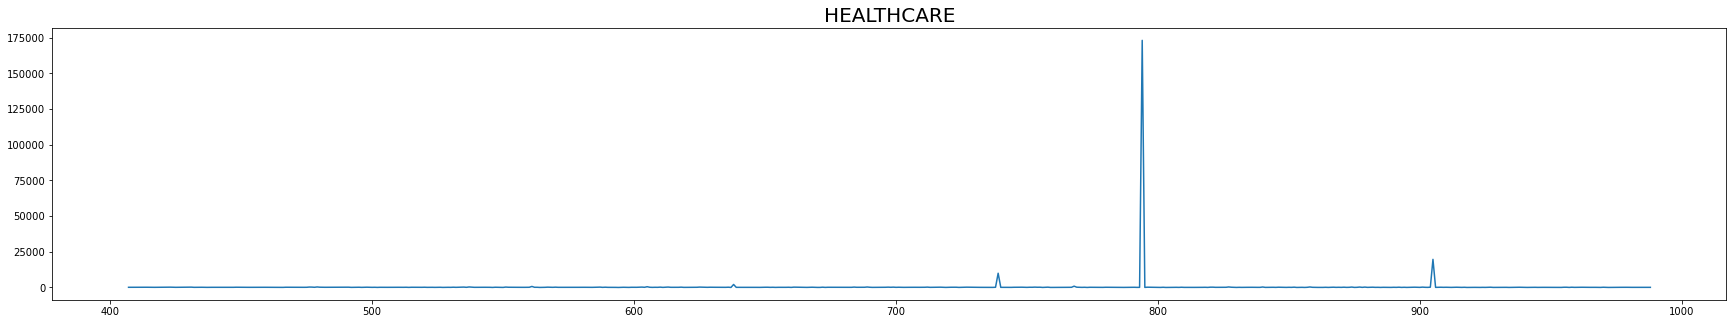

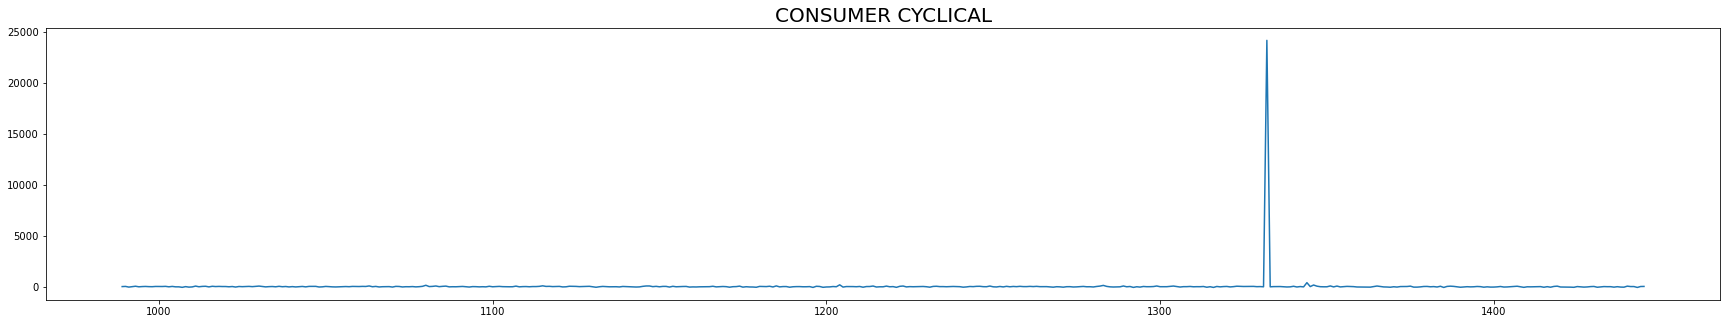

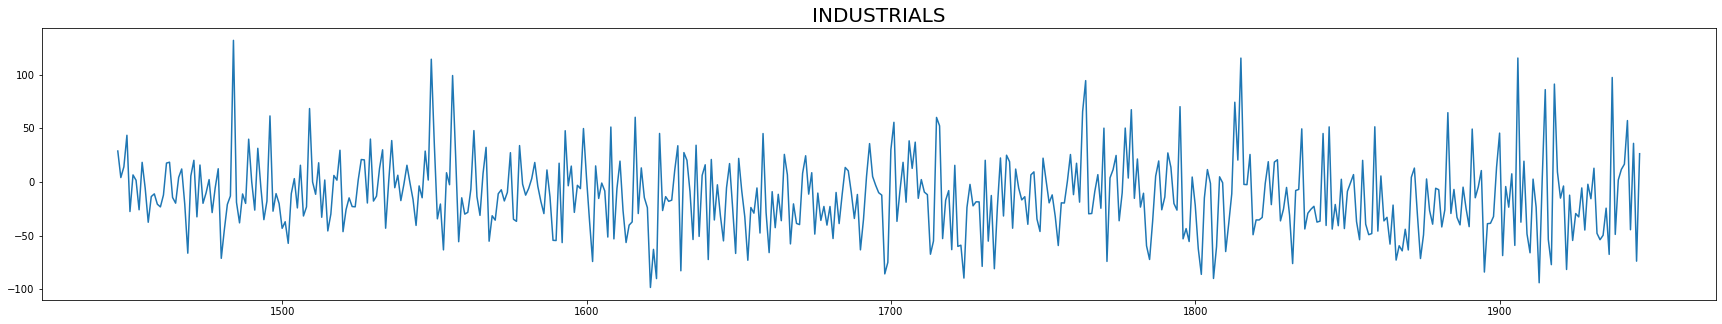

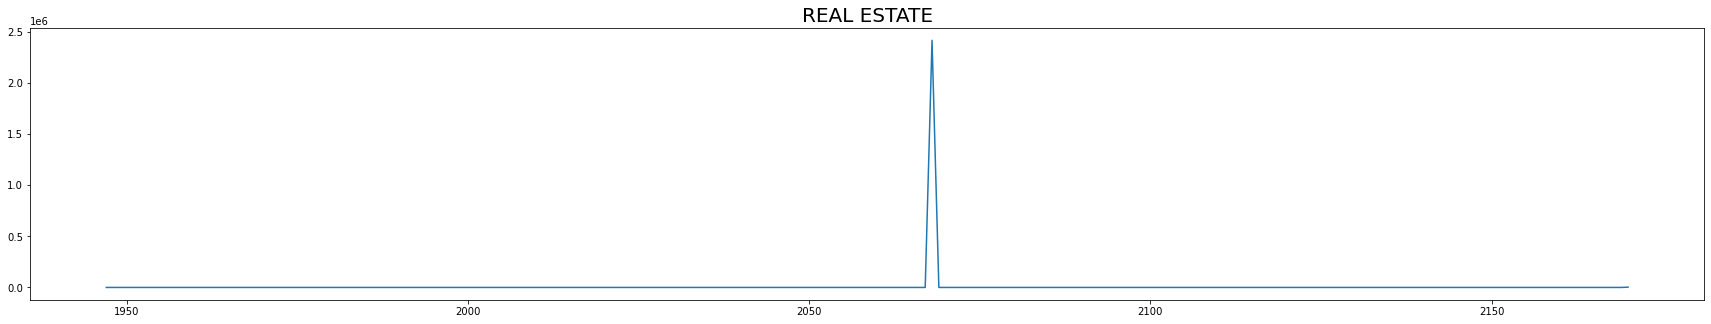

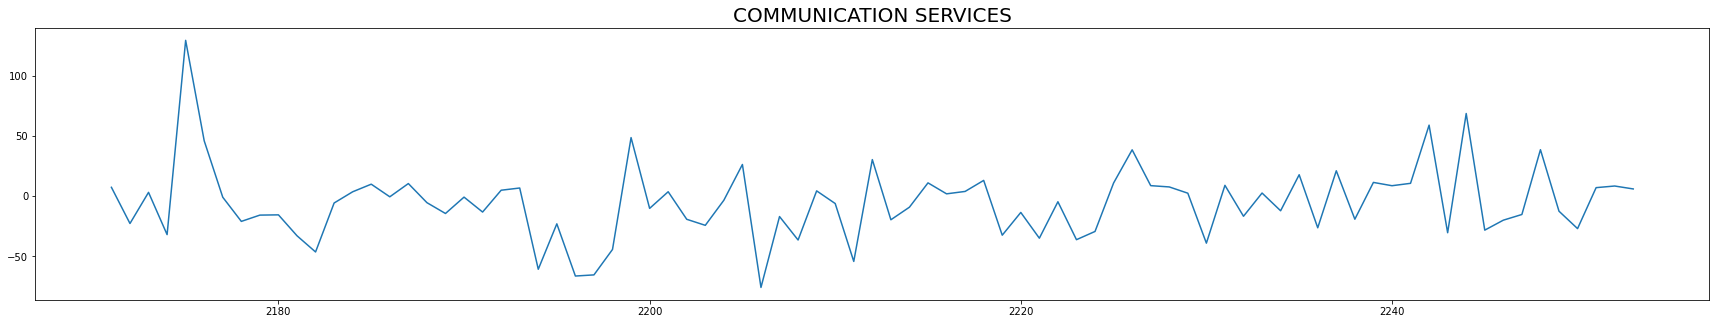

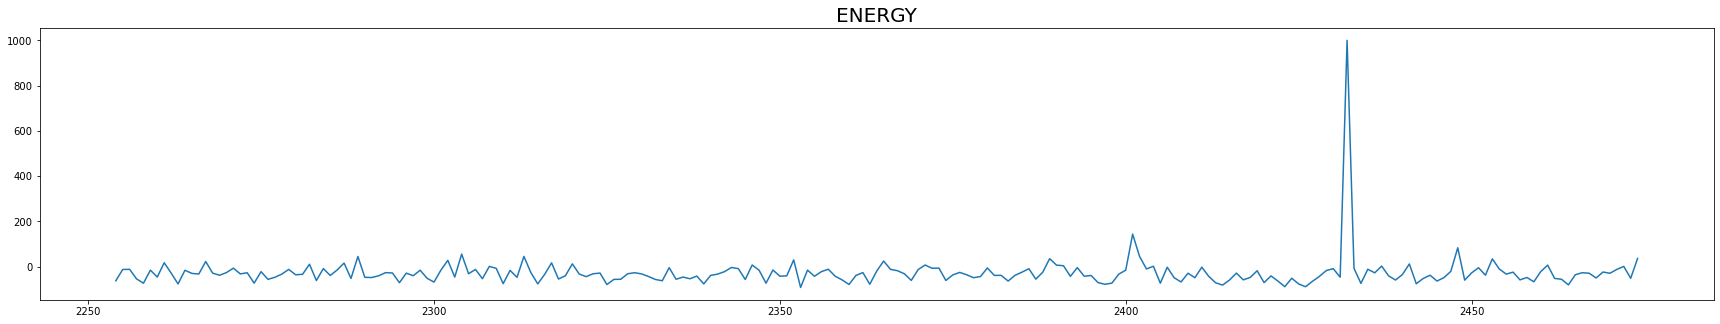

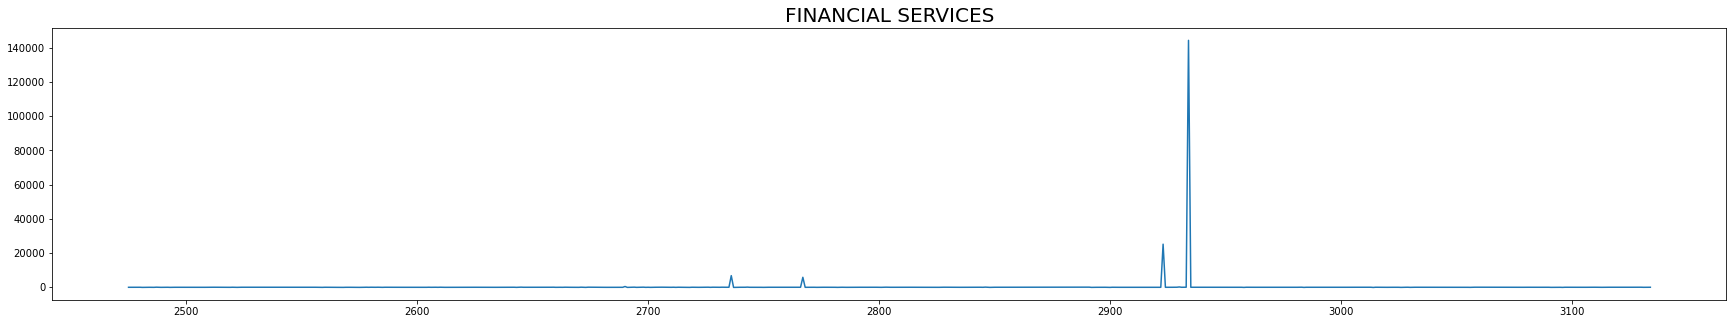

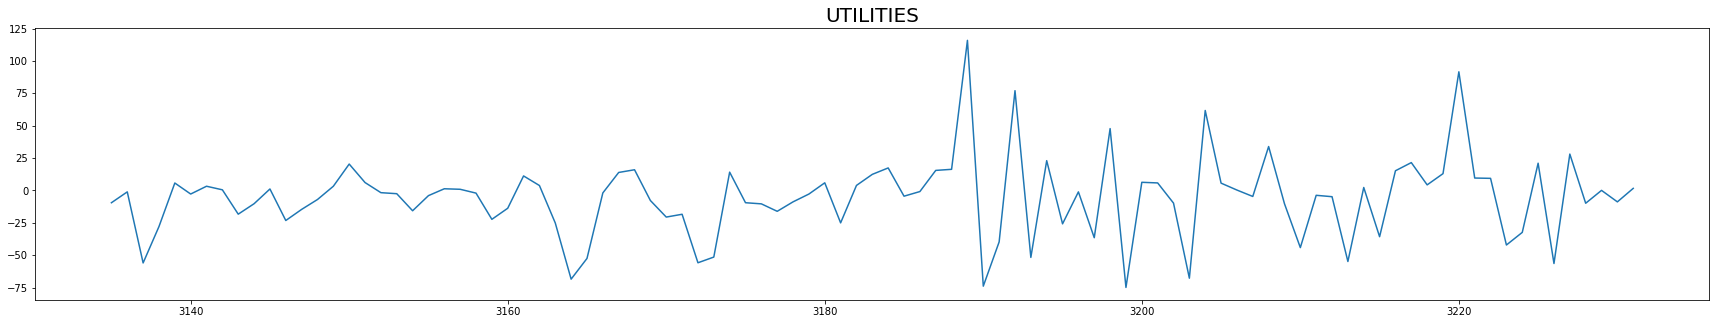

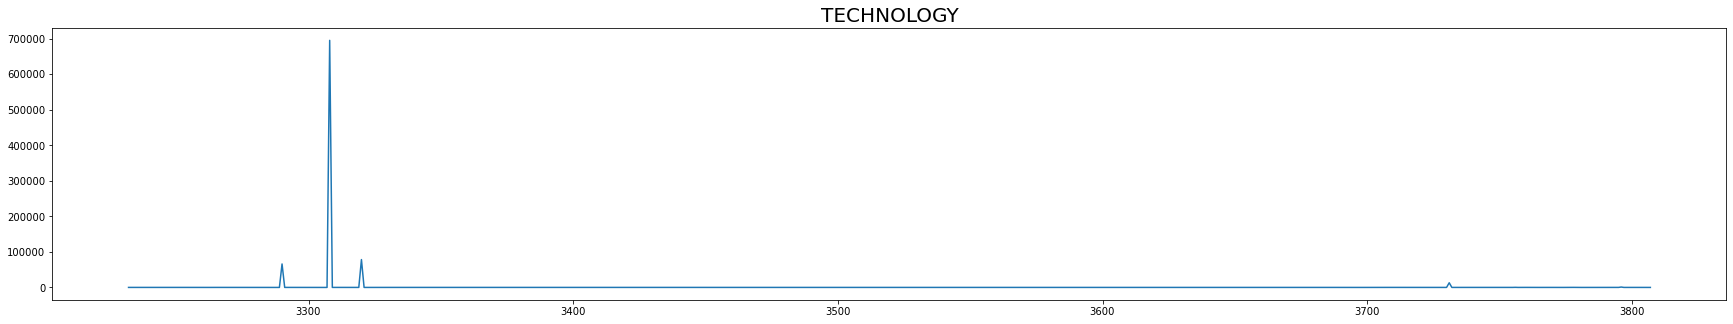

In [1548]:
dfp = ds2014.loc[:, ['Sector', price]]
sector_list = dfp["Sector"].unique()
for sector in sector_list:

    temp = dfp[dfp['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp[price])
    plt.title(sector.upper(), fontsize=20)
    plt.show()


### looking for missing values and how to handle them

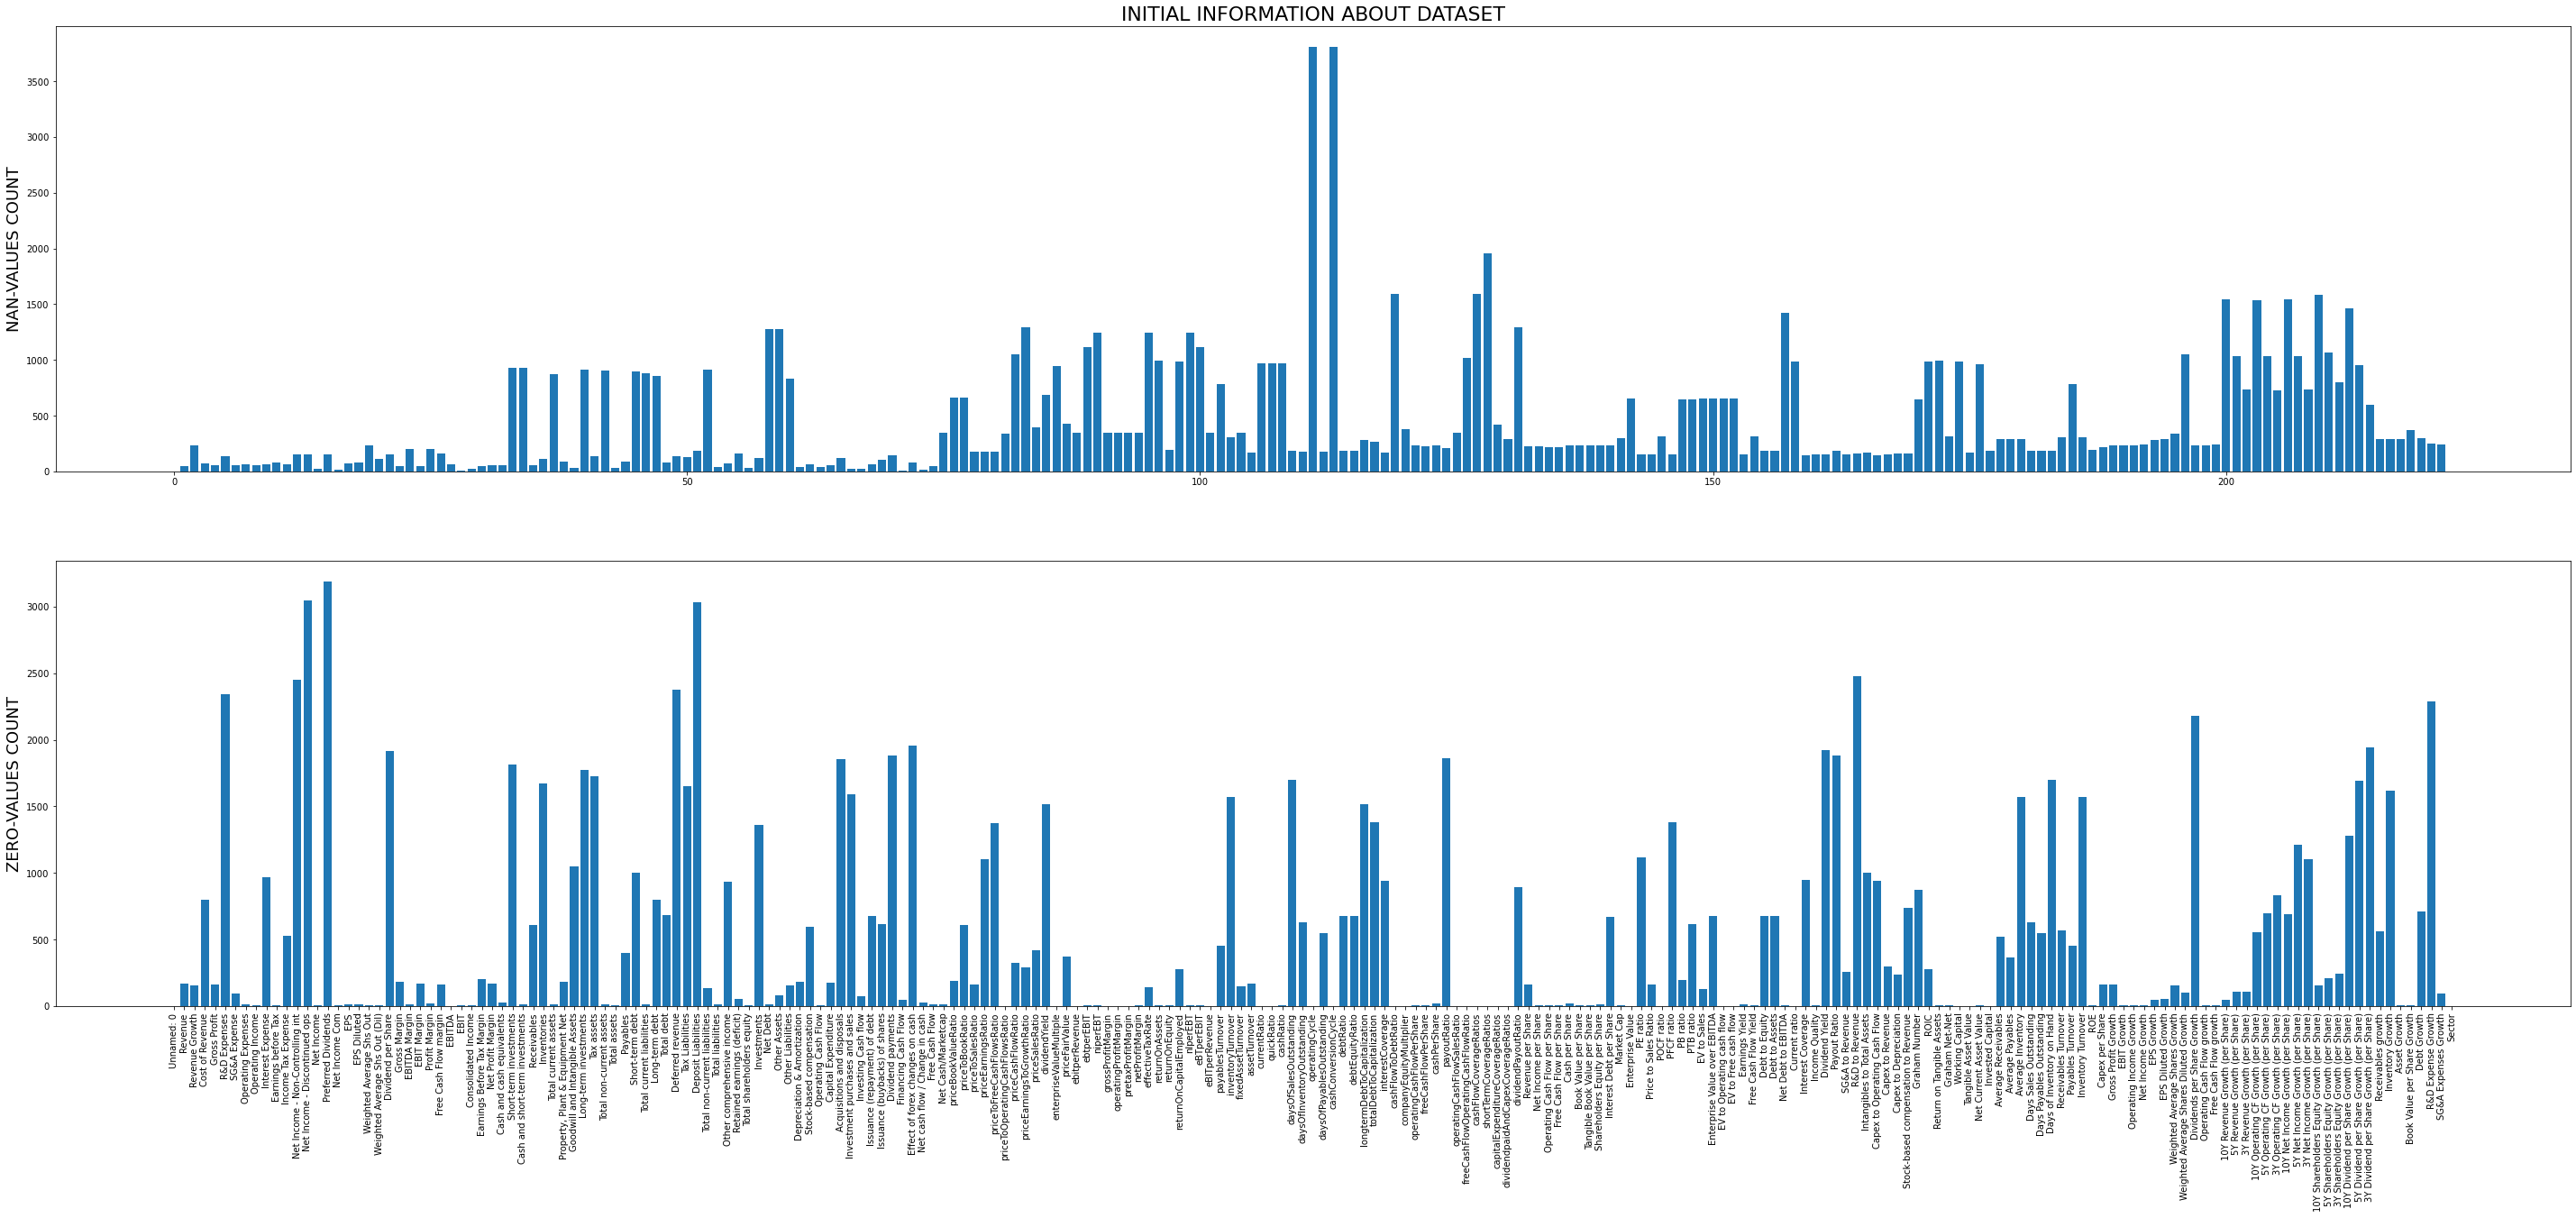

In [1549]:
# Drop columns relative to classification, we will use them later
class_data = ds2014.loc[:, [price,'Class']]
ds2014.groupby(["Sector"])
ds2014.drop(['Class', price], inplace=True, axis=1)

# Plot initial status of data quality in terms of nan-values and zero-values
nan_vals = ds2014.isna().sum()
zero_vals = ds2014.isin([0]).sum()
ind = np.arange(ds2014.shape[1])

plt.figure(figsize=(50,20))

plt.subplot(2,1,1)
plt.title('INITIAL INFORMATION ABOUT DATASET', fontsize=22)
plt.bar(ind, nan_vals.values.tolist())
plt.ylabel('NAN-VALUES COUNT', fontsize=18)

plt.subplot(2,1,2)
plt.bar(ind, zero_vals.values.tolist())
plt.ylabel('ZERO-VALUES COUNT', fontsize=18)
plt.xticks(ind, nan_vals.index.values, rotation='90')

plt.show()

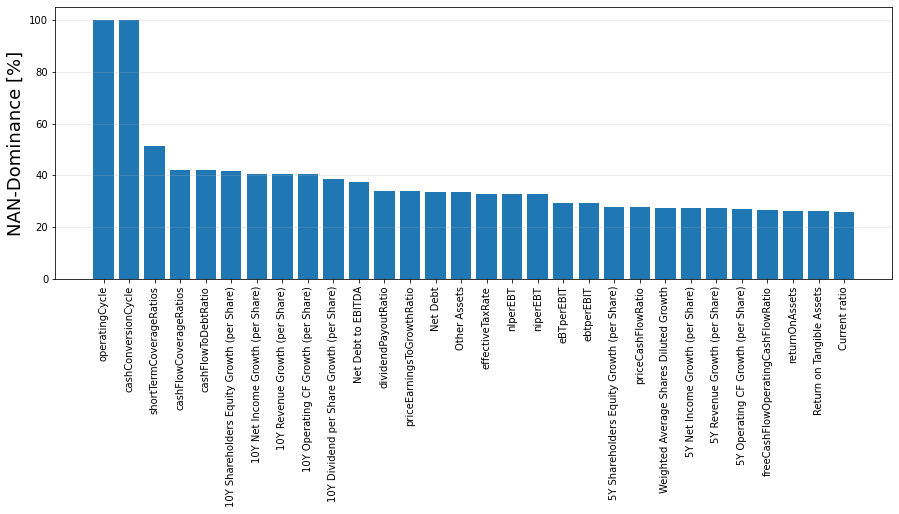

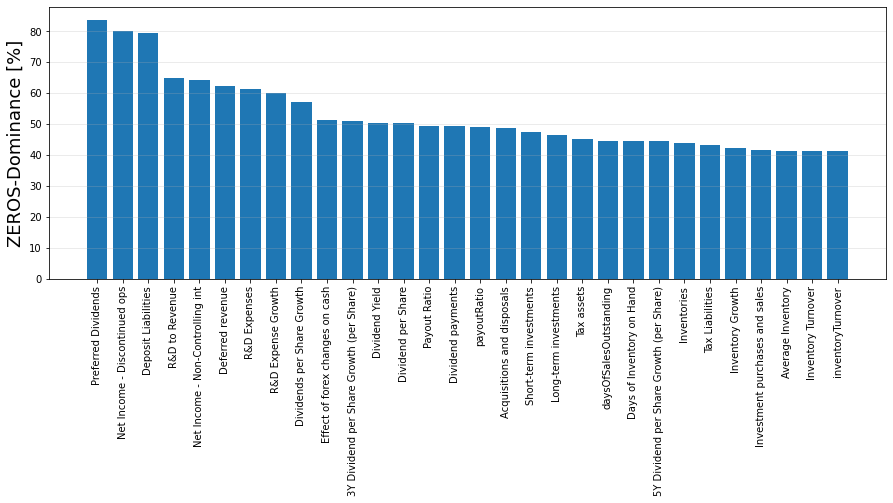

In [1550]:
# Find count and percent of nan-values, zero-values
total_nans = ds2014.isnull().sum().sort_values(ascending=False)
percent_nans = (ds2014.isnull().sum()/ds2014.isnull().count() * 100).sort_values(ascending=False)
total_zeros = ds2014.isin([0]).sum().sort_values(ascending=False)
percent_zeros = (ds2014.isin([0]).sum()/ds2014.isin([0]).count() * 100).sort_values(ascending=False)
df_nans = pd.concat([total_nans, percent_nans], axis=1, keys=['Total NaN', 'Percent NaN'])
df_zeros = pd.concat([total_zeros, percent_zeros], axis=1, keys=['Total Zeros', 'Percent Zeros'])

# Graphical representation
plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_nans['Percent NaN'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_nans['Percent NaN'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('NAN-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].values.tolist())
plt.xticks(np.arange(30), df_zeros['Percent Zeros'].iloc[:30].index.values.tolist(), rotation='90')
plt.ylabel('ZEROS-Dominance [%]', fontsize=18)
plt.grid(alpha=0.3, axis='y')
plt.show()

In [1551]:
# Find reasonable threshold for nan-values situation
test_nan_level = 0.5
print(df_nans.quantile(test_nan_level))
_, thresh_nan = df_nans.quantile(test_nan_level)

# Find reasonable threshold for zero-values situation
test_zeros_level = 0.6
print(df_zeros.quantile(test_zeros_level))
_, thresh_zeros = df_zeros.quantile(test_zeros_level)

Total NaN      232.000000
Percent NaN      6.092437
Name: 0.5, dtype: float64
Total Zeros      281.80000
Percent Zeros      7.40021
Name: 0.6, dtype: float64


In [1552]:
# Clean dataset applying thresholds for both zero values, nan-values
print(f'INITIAL NUMBER OF VARIABLES: {ds2014.shape[1]}')
print()

df_test1 = ds2014.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, 1)
print(f'NUMBER OF VARIABLES AFTER NaN THRESHOLD {thresh_nan:.2f}%: {df_test1.shape[1]}')
print()

df_zeros_postnan = df_zeros.drop((df_nans[df_nans['Percent NaN'] > thresh_nan]).index, axis=0)
df_test2 = df_test1.drop((df_zeros_postnan[df_zeros_postnan['Percent Zeros'] > thresh_zeros]).index, 1)
print(f'NUMBER OF VARIABLES AFTER Zeros THRESHOLD {thresh_zeros:.2f}%: {df_test2.shape[1]}')

INITIAL NUMBER OF VARIABLES: 223

NUMBER OF VARIABLES AFTER NaN THRESHOLD 6.09%: 114

NUMBER OF VARIABLES AFTER Zeros THRESHOLD 7.40%: 63


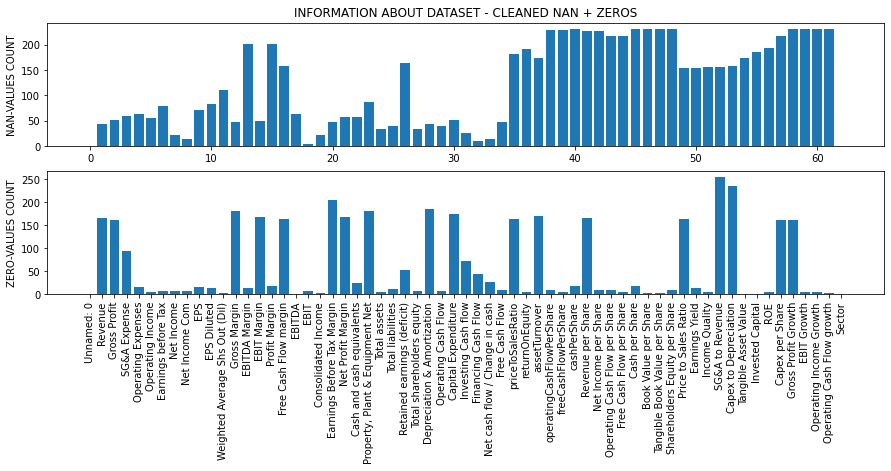

In [1553]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('INFORMATION ABOUT DATASET - CLEANED NAN + ZEROS', fontsize=12)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isnull().sum())
plt.ylabel('NAN-VALUES COUNT', fontsize=10)

plt.subplot(2,1,2)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isin([0]).sum())
plt.ylabel('ZERO-VALUES COUNT', fontsize=10)
plt.xticks(np.arange(df_test2.shape[1]), df_test2.columns.values, rotation='90')

plt.show()

In [1554]:
df_test2.describe()

,Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,...,SG&A to Revenue,Capex to Depreciation,Tangible Asset Value,Invested Capital,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Operating Cash Flow growth
count,3.764000e+03,3.756000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.728000e+03,3.785000e+03,3.793000e+03,3.736000e+03,3.724000e+03,...,3652.000000,3650.000000,3.635000e+03,3.623000e+03,3.615000e+03,3.590000e+03,3577.000000,3577.000000,3577.000000,3576.000000
mean,5.879050e+09,2.188214e+09,9.307406e+08,1.438144e+09,6.748248e+08,5.725866e+08,4.894335e+08,4.839166e+08,-2.607365e+04,-2.653476e+04,...,2.003619,-0.452700,1.756294e+10,1.934120e+10,1.941584e+03,-1.516578e+04,95.342800,3.631871,3.855939,-1.341505
std,3.901741e+10,1.159028e+10,4.820928e+09,7.305171e+09,3.786291e+09,2.793740e+09,4.396692e+09,4.392279e+09,1.672636e+06,1.673673e+06,...,34.124975,658.360878,1.213901e+11,1.376875e+11,1.167364e+05,3.855947e+05,5630.833201,228.011155,227.116093,74.436352
min,-6.276160e+08,-1.105000e+09,0.000000e+00,-1.088448e+09,-6.786000e+09,-8.878000e+09,-8.360000e+09,-8.360000e+09,-1.018709e+08,-1.018709e+08,...,-1.293500,-16522.069800,-2.101300e+09,-1.240000e+09,-7.101360e+01,-1.402752e+07,-48.793100,-1119.284200,-487.340900,-4028.397700
25%,5.788880e+07,3.092900e+07,1.548900e+07,3.106600e+07,-1.308000e+06,-3.732902e+06,-3.693000e+06,-4.369000e+06,-2.300000e-01,-2.400000e-01,...,0.092750,-1.672250,1.636885e+08,8.476944e+07,-2.075000e-02,-1.807475e+00,-0.010200,-0.269800,-0.254500,-0.328700
50%,4.349010e+08,1.908760e+08,7.381800e+07,1.386610e+08,4.104400e+07,2.842700e+07,2.223100e+07,2.101400e+07,7.700000e-01,7.500000e-01,...,0.222850,-0.917450,8.500508e+08,7.837860e+08,7.800000e-02,-4.848500e-01,0.072200,0.065500,0.061000,0.007350
75%,2.393625e+09,8.922534e+08,3.510000e+08,5.885100e+08,2.712980e+08,2.193835e+08,1.658440e+08,1.630900e+08,2.030000e+00,2.000000e+00,...,0.461800,-0.449300,3.896543e+09,4.159895e+09,1.532000e-01,-9.665000e-02,0.225700,0.406100,0.353700,0.341450
max,1.824698e+12,4.621600e+11,1.856830e+11,3.056050e+11,1.565540e+11,8.720500e+10,2.339970e+11,2.339970e+11,8.028004e+06,6.624003e+06,...,1540.600000,35298.333300,2.515999e+12,3.052798e+12,7.018763e+06,1.255873e+06,336767.800000,13562.153200,13545.338700,829.415100


In [1555]:
# Cut outliers
top_quantiles = df_test2.quantile(0.98, axis=1, interpolation="linear")
outliers_top = (df_test2 > top_quantiles)

low_quantiles = df_test2.quantile(0.01, axis=1, interpolation="linear")
outliers_low = (df_test2 < low_quantiles)

df_test2 = df_test2.mask(outliers_top, top_quantiles, axis=1)
df_test2 = df_test2.mask(outliers_low, low_quantiles, axis=1)
# Take a look at the dataframe post-outliers cut
df_test2.describe()

,Revenue,Gross Profit,SG&A Expense,Operating Expenses,Operating Income,Earnings before Tax,Net Income,Net Income Com,EPS,EPS Diluted,...,SG&A to Revenue,Capex to Depreciation,Tangible Asset Value,Invested Capital,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Operating Cash Flow growth
count,3.764000e+03,3.756000e+03,3.749000e+03,3.745000e+03,3.753000e+03,3.728000e+03,3.785000e+03,3.793000e+03,3.736000e+03,3.724000e+03,...,3652.000000,3650.000000,3.635000e+03,3.623000e+03,3.615000e+03,3.590000e+03,3577.000000,3577.000000,3577.000000,3576.000000
mean,5.879050e+09,2.188214e+09,9.307406e+08,1.438144e+09,6.748248e+08,5.725866e+08,4.894335e+08,4.839166e+08,-2.607365e+04,-2.653476e+04,...,2.003619,-0.452700,1.756294e+10,1.934120e+10,1.941584e+03,-1.516578e+04,95.342800,3.631871,3.855939,-1.341505
std,3.901741e+10,1.159028e+10,4.820928e+09,7.305171e+09,3.786291e+09,2.793740e+09,4.396692e+09,4.392279e+09,1.672636e+06,1.673673e+06,...,34.124975,658.360878,1.213901e+11,1.376875e+11,1.167364e+05,3.855947e+05,5630.833201,228.011155,227.116093,74.436352
min,-6.276160e+08,-1.105000e+09,0.000000e+00,-1.088448e+09,-6.786000e+09,-8.878000e+09,-8.360000e+09,-8.360000e+09,-1.018709e+08,-1.018709e+08,...,-1.293500,-16522.069800,-2.101300e+09,-1.240000e+09,-7.101360e+01,-1.402752e+07,-48.793100,-1119.284200,-487.340900,-4028.397700
25%,5.788880e+07,3.092900e+07,1.548900e+07,3.106600e+07,-1.308000e+06,-3.732902e+06,-3.693000e+06,-4.369000e+06,-2.300000e-01,-2.400000e-01,...,0.092750,-1.672250,1.636885e+08,8.476944e+07,-2.075000e-02,-1.807475e+00,-0.010200,-0.269800,-0.254500,-0.328700
50%,4.349010e+08,1.908760e+08,7.381800e+07,1.386610e+08,4.104400e+07,2.842700e+07,2.223100e+07,2.101400e+07,7.700000e-01,7.500000e-01,...,0.222850,-0.917450,8.500508e+08,7.837860e+08,7.800000e-02,-4.848500e-01,0.072200,0.065500,0.061000,0.007350
75%,2.393625e+09,8.922534e+08,3.510000e+08,5.885100e+08,2.712980e+08,2.193835e+08,1.658440e+08,1.630900e+08,2.030000e+00,2.000000e+00,...,0.461800,-0.449300,3.896543e+09,4.159895e+09,1.532000e-01,-9.665000e-02,0.225700,0.406100,0.353700,0.341450
max,1.824698e+12,4.621600e+11,1.856830e+11,3.056050e+11,1.565540e+11,8.720500e+10,2.339970e+11,2.339970e+11,8.028004e+06,6.624003e+06,...,1540.600000,35298.333300,2.515999e+12,3.052798e+12,7.018763e+06,1.255873e+06,336767.800000,13562.153200,13545.338700,829.415100


In [1556]:
# Replace nan-values with mean value of column, considering each sector individually. Remove Price Var that are bigger than 400, since it does not make too much sense of companies making more than 400% a year
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
df_test2 = df_test2.join(class_data)
df_test2 = df_test2[df_test2[price]<outliers_percentage]
#instead of using the mean of the sector, we try to sort them by a value that has low NAN and zero values, then we interpolate through them which makes more sense.
#df_test2.sort_values(by="Net cash flow / Change in cash") #EBIT, Operating Income, Capital expediture
df_test2 = df_test2.groupby(['Sector']).transform(lambda x: x.fillna(x.mean()))
df_test2.replace(0,df_test2.mean(axis=1),inplace=True)

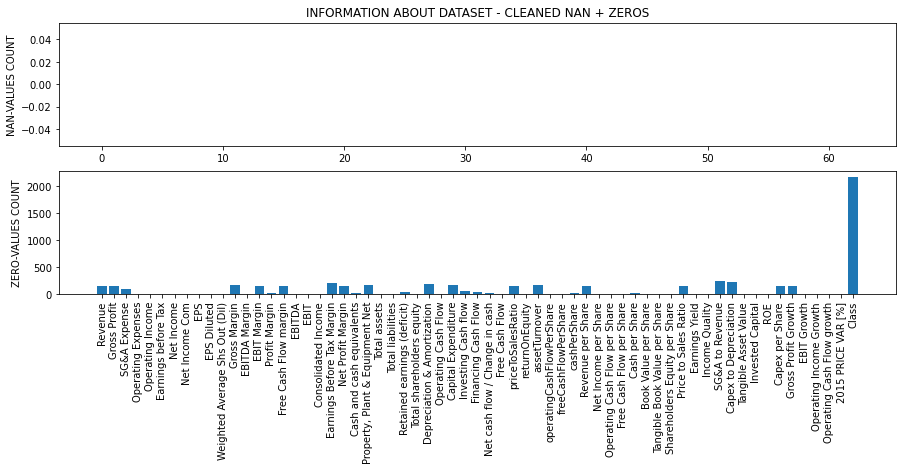

           Revenue  Gross Profit  SG&A Expense  Operating Expenses  \
0     7.440100e+10  3.537100e+10  2.146100e+10        2.146100e+10   
1     3.734148e+09  9.285226e+08  3.441414e+08        7.939267e+08   
2     9.837500e+10  2.023700e+10  1.519600e+10        1.751200e+10   
3     2.552641e+10  7.323734e+09  6.561162e+09        6.586482e+09   
4     1.790960e+10  6.369800e+09  3.474300e+09        3.412400e+09   
...            ...           ...           ...                 ...   
3803  4.952987e+07  8.278229e+06  8.253061e+06        8.253061e+06   
3804  1.532400e+08  1.340660e+08  1.125130e+08        1.162560e+08   
3805  4.200000e+07  1.500000e+07  1.400000e+07        1.500000e+07   
3806  3.407580e+08  2.481000e+07  1.651300e+07        1.651300e+07   
3807  4.033737e+07  1.904369e+07  1.098477e+07        1.436469e+07   

      Operating Income  Earnings before Tax    Net Income  Net Income Com  \
0         1.391000e+10         1.449400e+10  1.164300e+10    1.164300e+10   
1    

In [1557]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.title('INFORMATION ABOUT DATASET - CLEANED NAN + ZEROS', fontsize=12)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isnull().sum())
plt.ylabel('NAN-VALUES COUNT', fontsize=10)

plt.subplot(2,1,2)
plt.bar(np.arange(df_test2.shape[1]), df_test2.isin([0]).sum())
plt.ylabel('ZERO-VALUES COUNT', fontsize=10)
plt.xticks(np.arange(df_test2.shape[1]), df_test2.columns.values, rotation='90')
plt.show()
print(df_test2)

In [1558]:
# Add the sector column
df_out = df_test2.join(ds2014['Sector'])

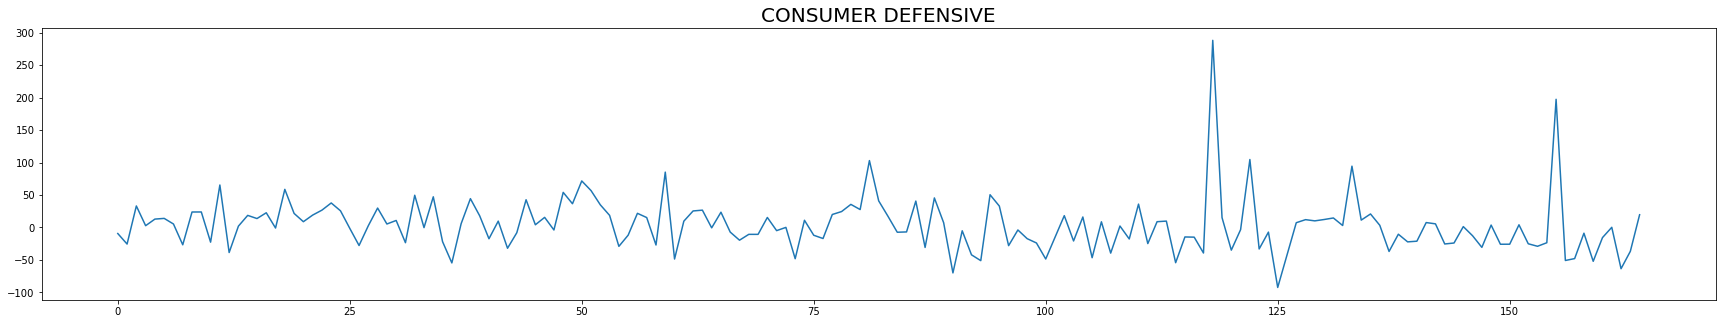

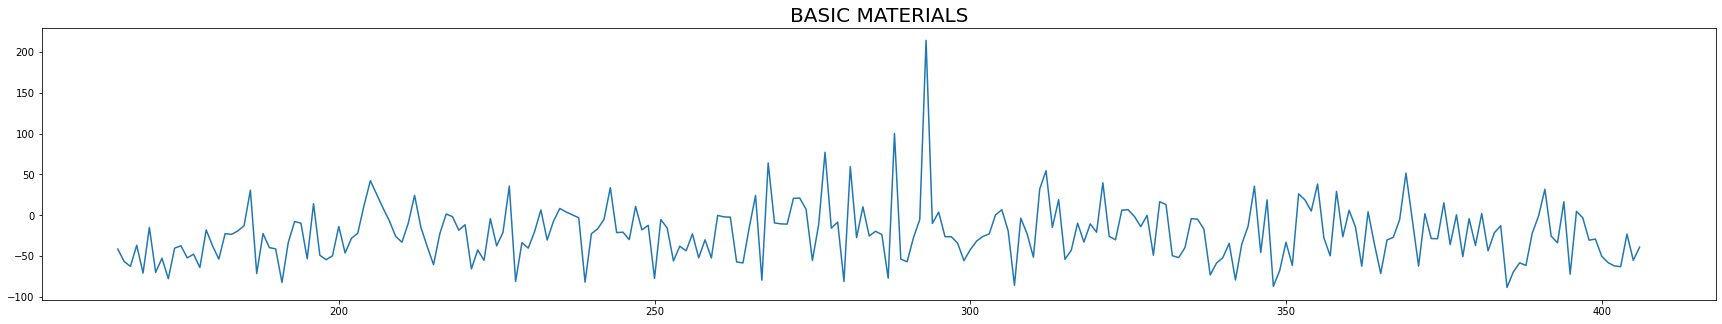

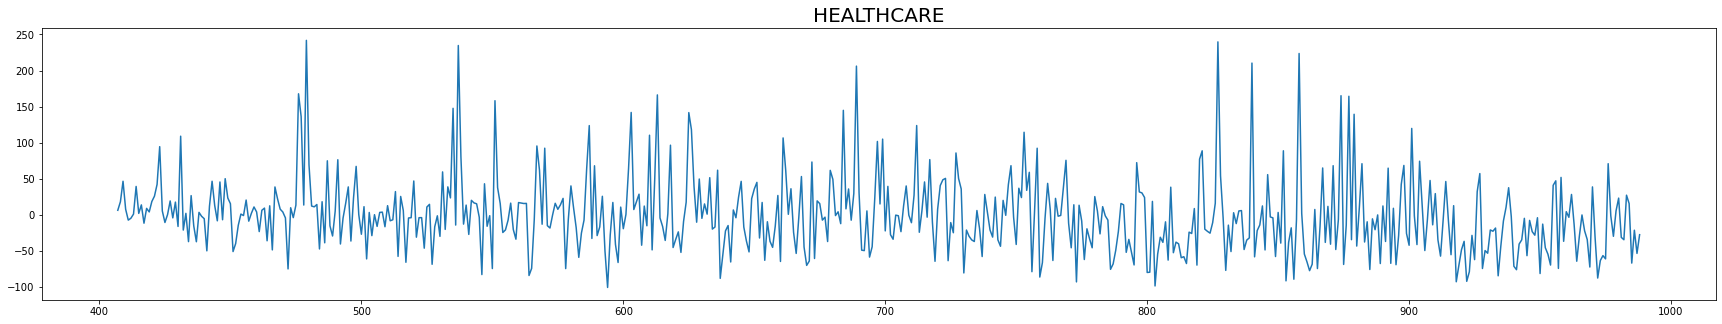

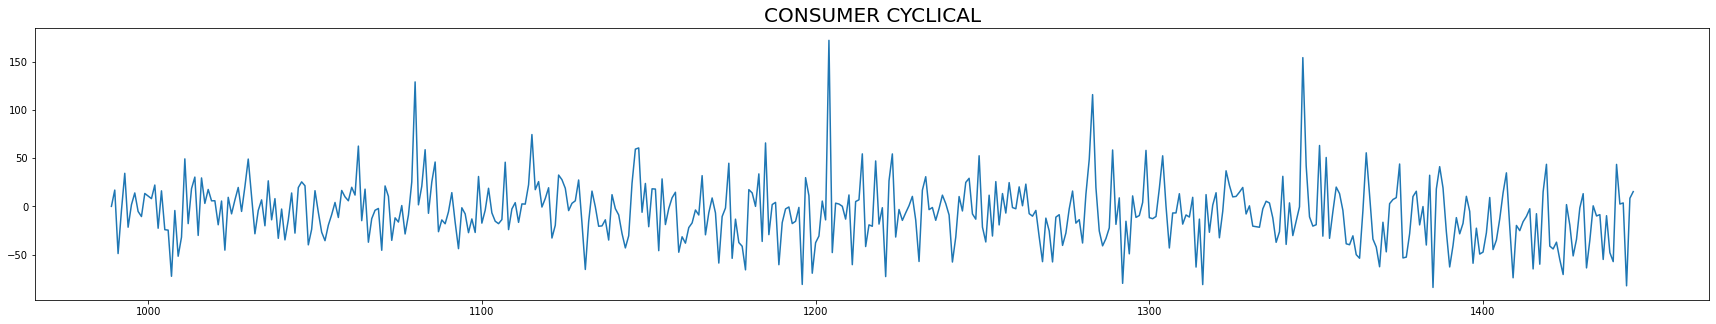

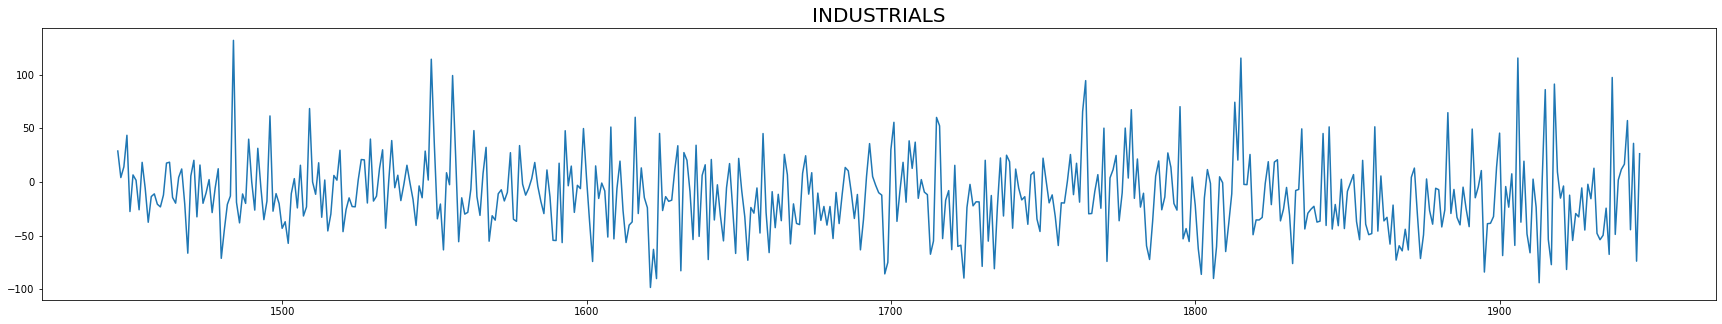

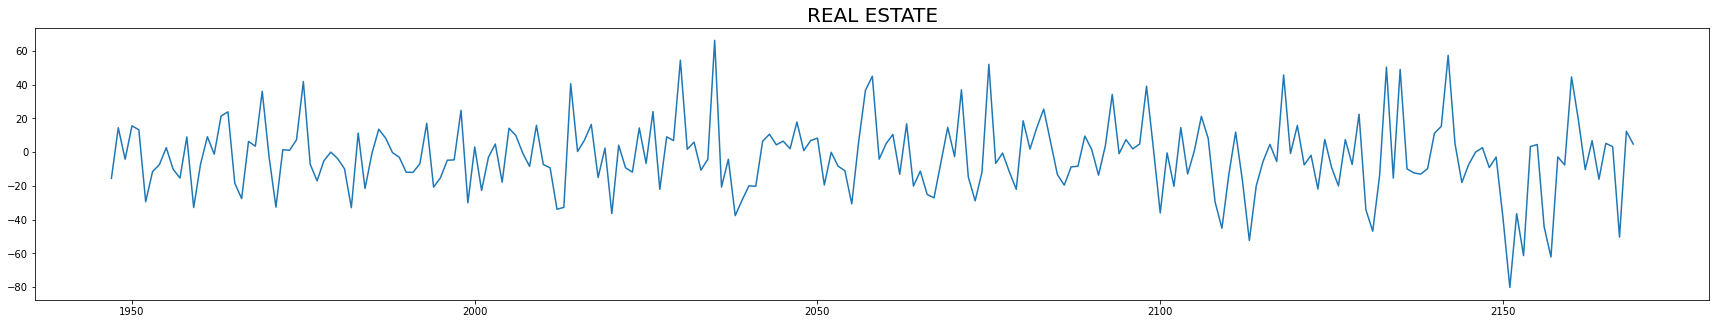

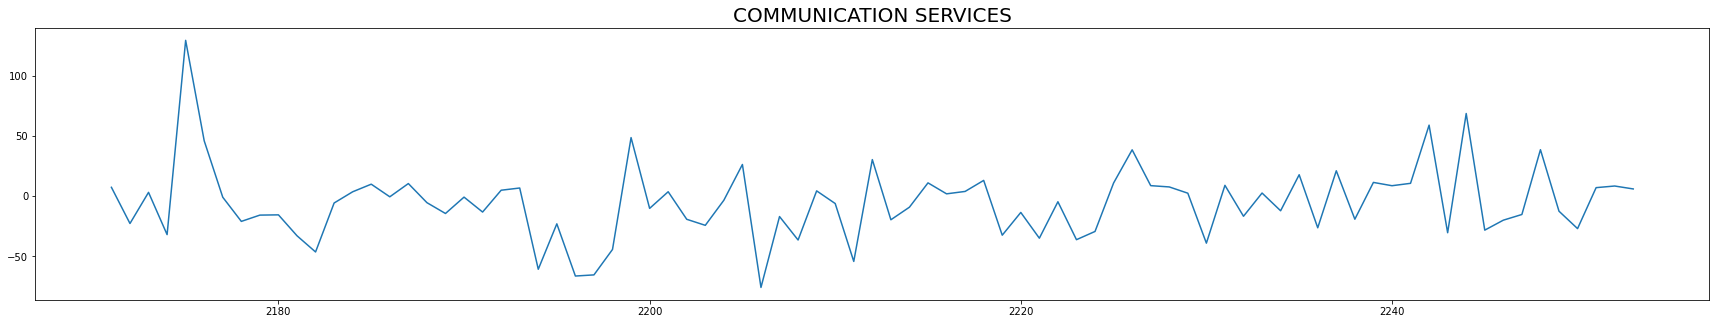

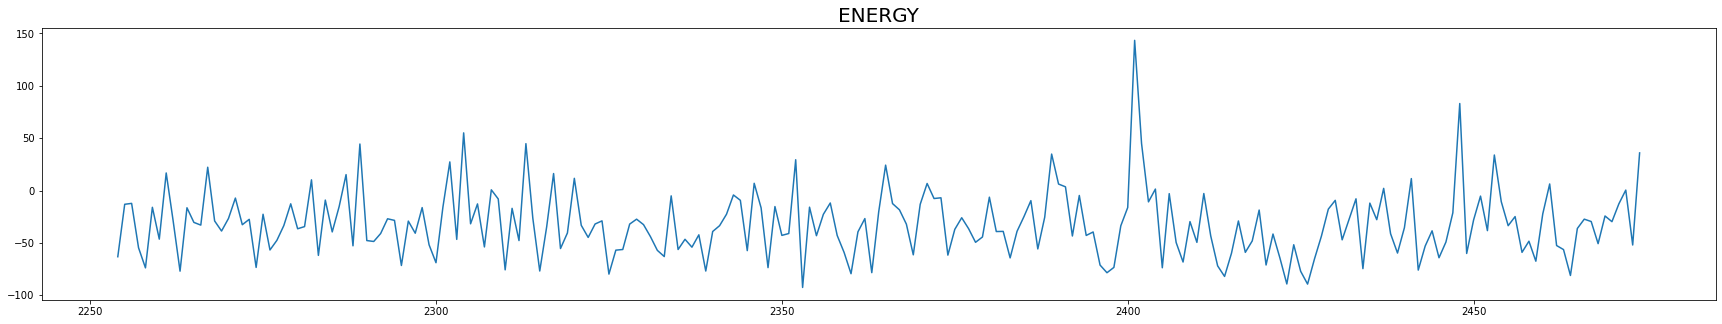

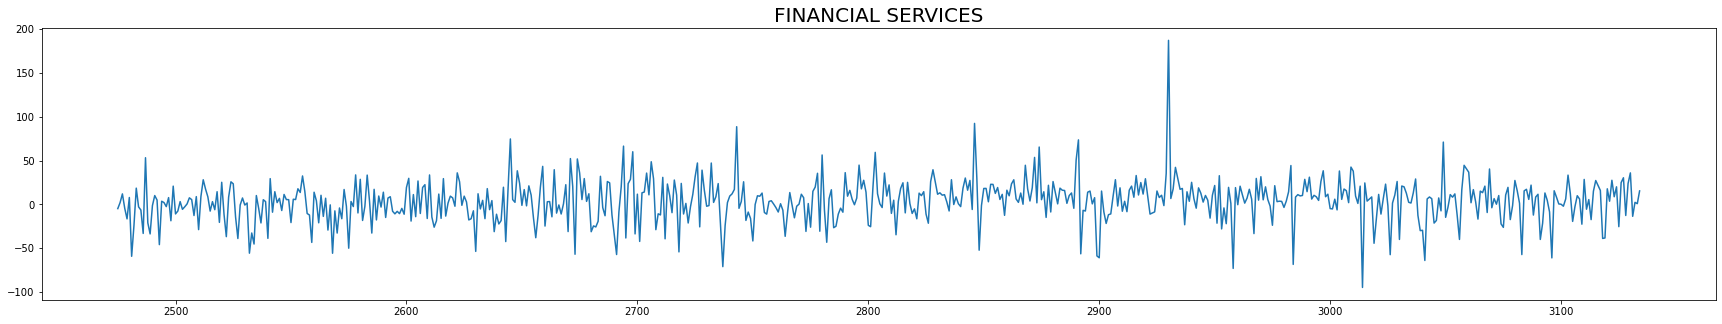

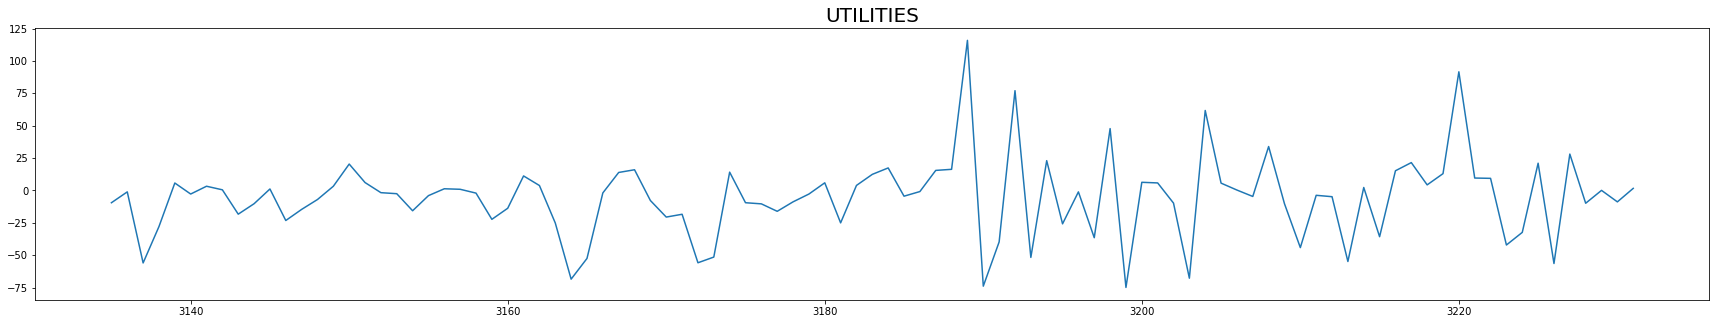

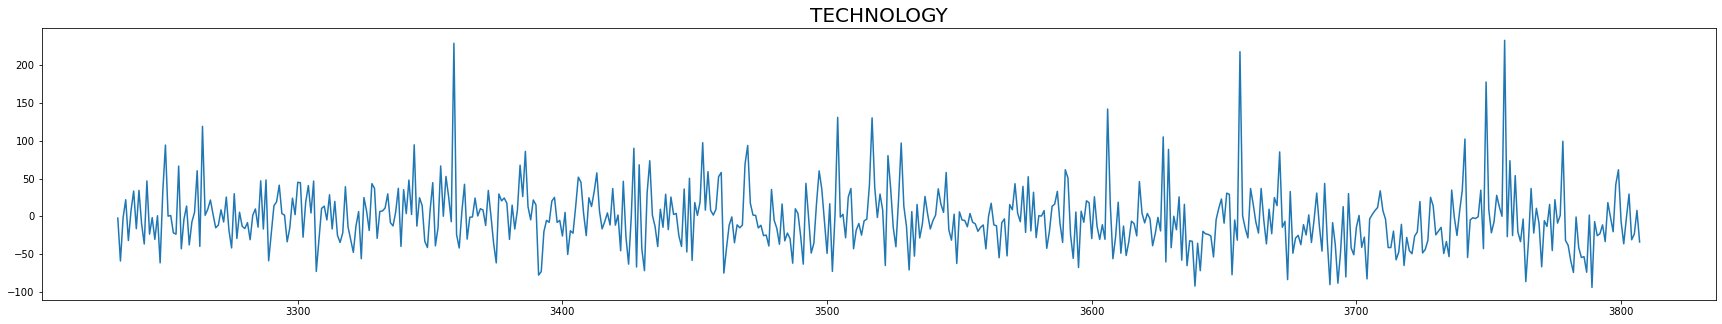

In [1559]:
# Handle outliers which have more than 500% gain per year
#df_out = (df_out[df_out["2016 PRICE VAR [%]"]<500])
dfp = df_out.loc[:, ['Sector', price]]
sector_list = dfp["Sector"].unique()
for sector in sector_list:

    temp = dfp[dfp['Sector'] == sector]

    plt.figure(figsize=(30,5))
    plt.plot(temp[price])
    plt.title(sector.upper(), fontsize=20)
    plt.show()

In [1560]:
df_out.loc[df_out[price]>sp500_2015_buy, "Class"] = 2
df_out.loc[df_out[price]<sp500_2015_sell, "Class"] = 0
df_out.loc[(df_out[price] >= sp500_2015_sell) & (df_out[price]<=sp500_2015_buy), "Class"] = 1

In [1561]:
# Save the cleaned data as ned .csv file
#df_out.to_csv(fileName)

In [1562]:
#sns.scatterplot(data=df_out, x = df_out["2019 PRICE VAR [%]"], y = df_out["Revenue Growth"], hue= df_out["Class"])
df_out = pd.get_dummies(df_out)
df_out.to_csv(fileName)